## 2. Preprocessing and Filtering EEG/MEG Data

**Goal:** Learn how to clean EEG/MEG data by filtering, marking bad channels, and preparing it for further analysis.

**Concepts Covered:**
- Band-pass filtering
- Identifying bad channels
- Re-referencing EEG (optional)
- Downsampling
- Saving preprocessed data

> **Note:** All plots are **static (non-interactive)** because Jupyter Notebook does not support MNE’s Qt interactive viewer. I did my best to see how to remove bad data



In [1]:
import mne
import matplotlib.pyplot as plt
import os
from pathlib import Path
import numpy as np
import pandas as pd

### Load Raw Data

In [2]:
data_path = mne.datasets.sample.data_path()
raw_fname = data_path / 'MEG' / 'sample' / 'sample_audvis_raw.fif'

raw = mne.io.read_raw_fif(raw_fname, preload=True)

# Pick EEG, EOG, and stimulus channels for preprocessing
raw.pick_types(meg=False, eeg=True, eog=True, stim=True)

print(raw.info)

Opening raw data file /Users/yibeisita/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
<Info | 19 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: STI 001, STI 002, STI 003, STI 004, STI 005, STI 006, STI 014, ...
 chs: 9 Stimulus, 59 EEG, 1 EOG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172

### Detecting Bad Channels

In interactive MNE plots, you can scroll through channels and mark bad ones.  
Since we are using static plots in Jupyter Notebook, we will detect bad channels programmatically.

**Steps:**
1. Compute basic statistics for EEG channel (e.g., standard deviation, peak-to-peak amplitude)  
2. Visualize the Power Spectral Density (PSD) across channels  
3. Identify channels that are **flat**, **very noisy**, or show abnormal frequency peaks  
4. Flag them by adding them to `raw.info['bads']`

In [3]:
# Pick only EEG channels in raw
raw_eeg = raw.copy().pick_types(eeg=True)

data, _ = raw.get_data(return_times=True)
ch_names = raw.ch_names

std_per_chan = np.std(data, axis=1)
ptp_per_chan = np.ptp(data, axis=1) 

# Compute average (mean or median) SD
avg_sd = np.mean(std_per_chan)
median_sd = np.median(std_per_chan)

print(f"Mean SD: {avg_sd:.6f}, Median SD: {median_sd:.6f}")

df_channels = pd.DataFrame({
    'Channel': ch_names,
    'StdDev (µV)': std_per_chan,
    'Peak-to-Peak (µV)': ptp_per_chan
})

# Sort by standard deviation to see extreme channels
df_channels_sorted = df_channels.sort_values('StdDev (µV)', ascending=False)
print("Top 10 EEG channels by StdDev (potentially noisy):")
print(df_channels_sorted.head(10))

print("\nBottom 10 EEG channels by StdDev (potentially flat):")
print(df_channels_sorted.tail(10))


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


Mean SD: 0.033564, Median SD: 0.000021
Top 10 EEG channels by StdDev (potentially noisy):
    Channel  StdDev (µV)  Peak-to-Peak (µV)
6   STI 014     0.971660          32.000000
0   STI 001     0.447667           5.000000
1   STI 002     0.429671           5.000000
2   STI 003     0.323916           5.000000
5   STI 006     0.141661           5.000000
68  EOG 061     0.000055           0.000977
11  EEG 003     0.000036           0.000585
15  EEG 007     0.000035           0.000541
9   EEG 001     0.000035           0.000599
10  EEG 002     0.000035           0.000584

Bottom 10 EEG channels by StdDev (potentially flat):
    Channel  StdDev (µV)  Peak-to-Peak (µV)
32  EEG 024     0.000018           0.000269
60  EEG 052     0.000017           0.000265
44  EEG 036     0.000017           0.000512
51  EEG 043     0.000017           0.000271
67  EEG 060     0.000017           0.000235
25  EEG 017     0.000017           0.000270
7   STI 015     0.000000           0.000000
3   STI 004     0.00

###  Plot PSD for All Channels
The **Power Spectral Density (PSD)** shows how much signal energy exists at each frequency.  
We use it to detect noisy channels or 50/60 Hz line noise.

Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_29295/3492994822.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_29295/3492994822.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


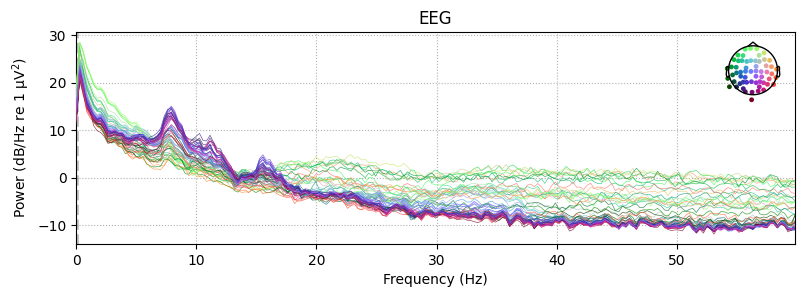

In [4]:
psd = raw.compute_psd(fmax=60)
fig = psd.plot(average=False, picks='eeg', show=False)
plt.tight_layout()
plt.show()

### Flag Bad Channels

In [5]:
raw.info['bads'] = ['EEG 017', 'EEG 024', 'EEG 026', 'EEG 035', 
                    'EEG 036', 'EEG 042', 'EEG 043', 'EEG 052', 
                    'EEG 056', 'EEG 060', 'EEG 003', 'EEG 007',
                    'EEG 010', 'EEG 001', 'EEG 002', 'EEG 008',
                    'EEG 004', 'EEG 006', 'EEG 005', 'EEG 015',
                    'EEG 010', 'STI 014']

Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_29295/169586737.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_29295/169586737.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


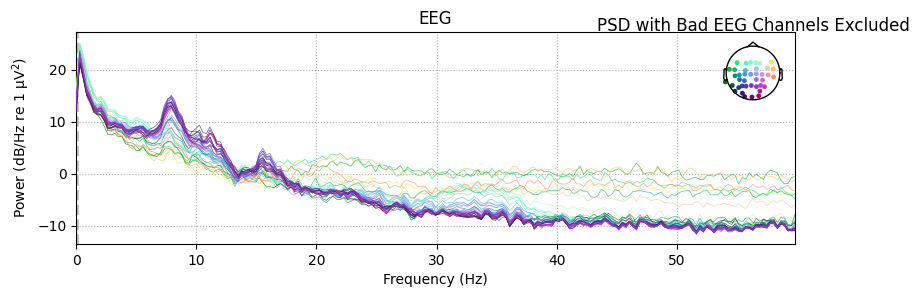

In [6]:
psd = raw.compute_psd(fmax=60)
fig = psd.plot(average=False, picks='eeg', exclude='bads', show=False)
plt.title("PSD with Bad EEG Channels Excluded")
plt.tight_layout()
plt.show()

### Filtering
Filters remove unwanted frequencies:  
- **High-pass filter** removes slow drifts (e.g., <1 Hz)  
- **Low-pass filter** removes high-frequency noise (>40 Hz)  
- **Notch filter** removes line noise (50 Hz or 60 Hz)

In [7]:
raw.filter(l_freq=1.0, h_freq=40.0, fir_design='firwin')
raw.notch_filter(freqs=[50, 100], fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1983 samples (3.302 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3965 samples (6.602 s)



<Raw | sample_audvis_raw.fif, 69 x 166800 (277.7 s), ~90.8 MiB, data loaded>

Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_29295/1910314774.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_29295/1910314774.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


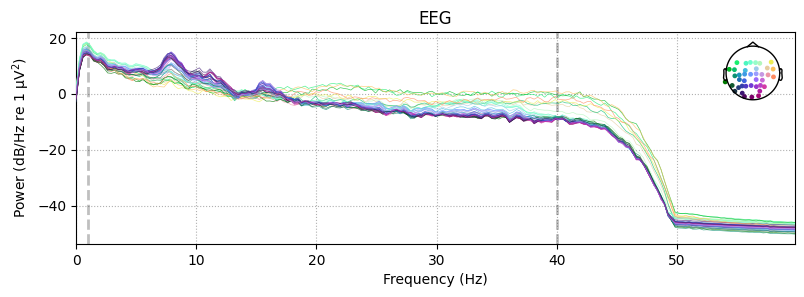

In [8]:
psd_filtered = raw.compute_psd(fmax=60)
fig2 = psd_filtered.plot(average=False, picks='eeg', exclude='bads', show=False)
plt.tight_layout()
plt.show()